In [1]:
from PIL import Image
from tensorflow.keras.utils import save_img, load_img, img_to_array, array_to_img

In [2]:
test_image = '../raw_data/hilma_study/hilma_original/11110032.jpg'

In [203]:
import os
from tqdm import tqdm

import torch
import clip
from torch.nn import functional as F
from sklearn.metrics import mean_squared_error
from conv_rgb.model import ConvRGB
import numpy as np

class TileEncoder:
    
    def __init__(self, model_name):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_name = model_name
        
        if self.model_name in clip.available_models():
            self.model, self.preprocess = clip.load(model_name, device=device)
            
        elif self.model_name == 'mobilenet':
            self.model = init_embedding_model_mobile()
            
        elif self.model_name == 'resnet50':
            self.model = init_embedding_model_resnet50()
            
        elif self.model_name == 'convrgb':
            self.model = ConvRGB(input_shape = (224, 224), n_cut = 6)
            
        elif self.model_name == 'pixel_mse':
            self.model = None
            
        else:
            print('Model name not in ..., defaulting to ViT-B/32')
            self.model, self.preprocess = clip.load("ViT-B/32", device=device)
    
    def divide_img_tiles(self, img, n_tiles=(5, 5)):
        horizontal = np.array_split(img, n_tiles[0])
        tiles_list = []
        for row in horizontal:
            for tile in np.array_split(row, n_tiles[1], axis=1):
                tiles_list.append(array_to_img(tile))
        return tiles_list
        
        
    def encode_images(self, preprocessed_tiles):
        with torch.no_grad():
            image_features = self.model.encode_image(preprocessed_tiles).float()
        return image_features
    
    
    def get_features(self, img):
        
        img_tiles = self.divide_img_tiles(img)

        p_img_tiles = torch.tensor(np.stack([self.preprocess(tile).to(device) for tile in img_tiles]))

        tiles_features = self.encode_images(p_img_tiles)
        
        return tiles_features, img_tiles
    
    
    def spherical_dist_loss(self, x, y):
        """from github.com/crowsonkb/k-diffusion/sample_clip_guided.py, 
        adapted to accept a tensorflow tensor"""
        if tf.is_tensor(x) and tf.is_tensor(y):
            x, y = torch.from_numpy(x.numpy()), torch.from_numpy(y.numpy())
            x = F.normalize(x, dim=-1)
            y = F.normalize(y, dim=-1)
            loss = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
            return loss.numpy()
        
        else:
            x = F.normalize(x, dim=-1)
            y = F.normalize(y, dim=-1)
            loss = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
            return loss.item()
        
        
    def mse_distance(self, pil_img_one, pil_img_two):        
        
        img_tiles_one = self.divide_img_tiles(img_to_array(pil_img_one.resize((50, 50))))
        img_tiles_two = self.divide_img_tiles(img_to_array(pil_img_two.resize((50, 50))))
        
        all_tile_combos = list(((x,y) for x in range(len(img_tiles_one)) for y in range(len(img_tiles_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            mse = np.mean((img_to_array(img_tiles_one[one_id]) - img_to_array(img_tiles_two[two_id])) ** 2)
            distance_list.append(mse)
            
        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]

        return sorted_combos, (img_tiles_one, img_tiles_two)
    

    def clip_feature_distance(self, pil_img_one, pil_img_two):
    
        features_one, tiles_one = self.get_features(img_to_array(pil_img_one))
        features_two, tiles_two = self.get_features(img_to_array(pil_img_two))
        
        all_tile_combos = list(((x,y) for x in range(len(features_one)) for y in range(len(features_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            sph_dist = self.spherical_dist_loss(features_one[one_id], features_two[two_id])
            distance_list.append(sph_dist)
            
        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]
        #sorted_combos = [{'x_id': combo[0], 'y_id': combo[1], 'dist' : distance} for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])] 

        return sorted_combos, (tiles_one, tiles_two)
    
    
    def img_feature_distance(self, pil_img_one, pil_img_two):
        img_tiles_one = self.divide_img_tiles(img_to_array(pil_img_one))
        img_tiles_two = self.divide_img_tiles(img_to_array(pil_img_two))
         
        features_one = self.model(np.stack([img_to_array(tile.resize((224, 224))) for tile in img_tiles_one]))
        features_two = self.model(np.stack([img_to_array(tile.resize((224, 224))) for tile in img_tiles_two]))
        
        all_tile_combos = list(((x,y) for x in range(len(img_tiles_one)) for y in range(len(img_tiles_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            sph_dist = self.spherical_dist_loss(features_one[one_id], features_two[two_id])
            distance_list.append(sph_dist.item())

        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]

        return sorted_combos, (img_tiles_one, img_tiles_two)

    
    def colour_distance(self, pil_img_one, pil_img_two):
            
        img_tiles_one = self.divide_img_tiles(img_to_array(pil_img_one))
        img_tiles_two = self.divide_img_tiles(img_to_array(pil_img_two))
        
        features_one = self.model(np.stack([img_to_array(tile.resize((224, 224))) for tile in img_tiles_one]))
        features_two = self.model(np.stack([img_to_array(tile.resize((224, 224))) for tile in img_tiles_two]))
        
        all_tile_combos = list(((x,y) for x in range(len(img_tiles_one)) for y in range(len(img_tiles_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
#             sph_dist = self.spherical_dist_loss(features_one[one_id], features_two[two_id])
#             distance_list.append(sph_dist)
            mae = np.mean((features_one[one_id] - features_two[two_id]) ** 2)
            distance_list.append(mae)

        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]   
    
        return sorted_combos, (img_tiles_one, img_tiles_two)
        
    
    
    def get_image_similarites(self, pil_img_one, pil_img_two):
        
        if self.model_name in clip.available_models():
            sorted_combos, (img_tiles_one, img_tiles_two) = self.clip_feature_distance(pil_img_one, pil_img_two)
            
        if self.model_name == 'resnet50' or self.model_name == 'mobilenet':
            sorted_combos, (img_tiles_one, img_tiles_two) = self.img_feature_distance(pil_img_one, pil_img_two)
            
        if self.model_name == 'convrgb':
            sorted_combos, (img_tiles_one, img_tiles_two) = self.colour_distance(pil_img_one, pil_img_two)
            
        if self.model_name == 'pixel_mse':
            sorted_combos, (img_tiles_one, img_tiles_two) = self.mse_distance(pil_img_one, pil_img_two)
            
        return sorted_combos, (img_tiles_one, img_tiles_two)

In [204]:
# import tensorflow as tf

# def init_embedding_model():
#     """ define a pretrained convolutional model from tensorflow to extract features from an array of images"""
#     model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
#     new_input = model.input
#     hidden_layer = model.layers[-1].output
#     model_new = tf.keras.Model(new_input, hidden_layer)
#     return model_new


# def extract_features(model, image_path):
#     """ extract features from an image using the pretrained model"""
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (224, 224))
#     img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
#     img = np.expand_dims(img, axis=0)
#     features = model.predict(img)
#     return features


# def get_features(model, image_paths):
#     """ extract features from a list of images"""
#     features = []
#     for image_path in image_paths:
#         features.append(extract_features(model, image_path))
#     return features

In [205]:
def init_embedding_model_mobile():
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.layers.Resizing(224, 224)(x)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
    x = core(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    return model


def init_embedding_model_resnet50():
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.layers.Resizing(224, 224)(x)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    core = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
    x = core(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    return model

In [206]:
# model = init_embedding_model_resnet50()
# out = model(np.array([img_to_array(orginal_img)]))
# model.summary()
# out.shape

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 4, 4, 3)           49287     
                                                                 
 flatten_36 (Flatten)        (None, 48)                0         
                                                                 
Total params: 49,287
Trainable params: 49,287
Non-trainable params: 0
_________________________________________________________________


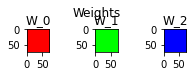

In [207]:
ConvRGB(input_shape = (224, 224), n_cut = 3).summary()

In [208]:
#tile_encoder = TileEncoder("ViT-B/32") # "ViT-L/14"

tile_encoder = TileEncoder(model_name = "convrgb")

In [209]:
orginal_img = Image.open('../raw_data/hilma_study/hilma_original/11110045.jpg')

In [210]:
# output_img= Image.open('../raw_data/hilma_study/hilma_dalle/DALL·E 2022-07-26 16.32.17 - By Hilma af Klint.png')

In [211]:
def get_image_paths(folder, limit = None):
    image_paths = []
    for file in os.listdir(f"{folder}"):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.webp') or file.endswith('.png'):
            image_paths.append(f'{folder}/{file}')
    if limit:
        image_paths = image_paths[:min([limit, len(image_paths)])]
    return image_paths

In [212]:
folder = '../raw_data/hilma_study/hilma_dalle'

compare_distances = []
compare_tile_combos = []
tiles_list = []
img_list = []

print("Number of comparisons: ", len(os.listdir(f"{folder}")))

for file_name in tqdm(get_image_paths(folder)):
    #sorted_combos, tiles = tile_encoder.clip_feature_distance(orginal_img, Image.open(f'{folder}/{file}'))
    #sorted_combos, tiles = tile_encoder.mse_distance(orginal_img, Image.open(file_name))
    sorted_combos, tiles = tile_encoder.get_image_similarites(orginal_img, Image.open(file_name))
    
    compare_tile_combos.append(sorted_combos)
    compare_distances.append([results_tup[2] for results_tup in sorted_combos])
    tiles_list.append(tiles)
    img_list.append((orginal_img, Image.open(file_name)))
        
        

Number of comparisons:  132


100%|█████████████████████████████████████████| 132/132 [01:05<00:00,  2.01it/s]


In [213]:
closest_ten = np.argsort(np.min(np.array(compare_distances), axis = 1))[:10] # choose number of comparison images

combos_of_interest = [combos for idx, combos in enumerate(compare_tile_combos) if idx in closest_ten]
tiles_of_interest = [tiles for idx, tiles in enumerate(tiles_list) if idx in closest_ten]
img_of_interest = [img for idx, img in enumerate(img_list) if idx in closest_ten]

In [228]:
# sort all images by 
# closest tile = np.min
# avg tile = np.mean

# slower because im object numpy arrays but keeps all idx

# can maybe use the same zip sort trick here and sort by np.min etc


sorted_idx = np.argsort(np.min(np.array(compare_distances), axis = 1))

sorted_compare_tile_combos = np.array(compare_tile_combos)[sorted_idx]
sorted_tiles_of_interest = np.array(tiles_list, dtype = object)[sorted_idx]
sorted_img_of_interest = np.array(img_list, dtype = object)[sorted_idx]

# combos_of_interest = [combos for idx, combos in enumerate() if idx in closest_ten]
# tiles_of_interest = [tiles for idx, tiles in enumerate(tiles_list) if idx in closest_ten]
# img_of_interest = [img for idx, img in enumerate(img_list) if idx in closest_ten]

/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_19551/2125405421.py:8: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sorted_tiles_of_interest = np.array(tiles_list, dtype = object)[sorted_idx]
/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_19551/2125405421.py:9: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. T

In [214]:
# # plot closest tiles
# interest_idx = np.argsort(np.array(compare_distances).reshape(-1))[:10] # choose number of comparison tiles

# img_idx, tile_idx = np.unravel_index(interest_idx, np.array(compare_distances).shape)

# combos_of_interest = [combos for idx, combos in enumerate(compare_tile_combos) if idx in img_idx]
# tiles_of_interest = [tiles for idx, tiles in enumerate(tiles_list) if idx in img_idx]
# img_of_interest = [img for idx, img in enumerate(img_list) if idx in img_idx]

In [215]:
len(combos_of_interest)

10

In [217]:
# from sklearn.metrics import mean_squared_error, 

# def norm_mse_loss(x, y):
#     x = F.normalize(x, dim=-1)
#     y = F.normalize(y, dim=-1)
#     return mean_squared_error(x, y)

In [218]:
import matplotlib.pyplot as plt

def plot_tiles(org_tiles, output_tiles, org_highlight_idx = None, output_highlight_idx = None):
    fig = plt.figure(constrained_layout=True, figsize = (16, 9))

    subfigs = fig.subfigures(1, 2)

    for subfig, img_tiles, title, highlight_ids in zip(subfigs.flat, 
                                               [org_tiles, output_tiles], 
                                               ['Original', 'AI Generated'], 
                                               [org_highlight_idx, output_highlight_idx]):
        axes = subfig.subplots(5, 5)
        plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=None, wspace=0.03, hspace=0.03)
        for idx, ax in enumerate(axes.flat):
            if idx == 2:
                ax.set_title(f'{title}', fontsize = 24)
            ax.imshow(img_tiles[idx])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            if highlight_ids:
                if type(highlight_ids) == int: 
                    highlight_ids = [highlight_ids] # convert to list if only one number
                if idx in highlight_ids:
                    plt.setp(ax.spines.values(), color='red', linewidth=7)
                
#plot_tiles(tiles_of_interest[0][0], tiles_of_interest[0][1], org_highlight_idx = org_match, output_highlight_idx = output_match)

In [219]:
# width = img_tiles[0].size[0]
# height = img_tiles[0].size[1]

def get_tile_bbox(tile_idx, width, height):
    
    coords = np.array(np.unravel_index(tile_idx, (5,5)))

    x = coords[1] * height
    y = coords[0] * width

    x_coords = [x, x, x + height -1 , x + height - 1, x] # coords for box, len 5 to wrap around
    y_coords = [y, y + width, y + width, y, y]
                
    return x_coords, y_coords

get_tile_bbox(5, 250, 250)

([0, 0, 249, 249, 0], [250, 500, 500, 250, 250])

In [220]:
def plot_comparison(img_one, img_two, org_highlight_idx = None, output_highlight_idx = None):
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 9))

    for ax, img, title, highlight_ids in zip(axes.flat, 
                                               [img_one, img_two], 
                                               ['Original', 'AI Generated'], 
                                               [org_highlight_idx, output_highlight_idx]):
        
        ax.set_title(f'{title}', fontsize = 24)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        ax.set_xlim(0, img.size[0])
        ax.set_ylim(img.size[1], 0)
        
        width = img.size[1] // 5
        height = img.size[0] // 5
                
#         width = img_tiles[0].size[0]
#         height = img_tiles[0].size[1] # get tile size, need to get elsewhere
        
        bb_coords = [get_tile_bbox(idx, width, height) for idx in highlight_ids] # 5, 5 from number of splits
        
        
        for box in bb_coords:
            ax.plot(box[0], box[1], c = 'r')

org:  {7}
gen:  {10}
org:  {7}
gen:  {13}
org:  {18}
gen:  {22}
org:  {17}
gen:  {15}
org:  {17}
gen:  {17}
org:  {17}
gen:  {24}
org:  {18}
gen:  {12}
org:  {17}
gen:  {23}
org:  {7}
gen:  {17}
org:  {7}
gen:  {0}


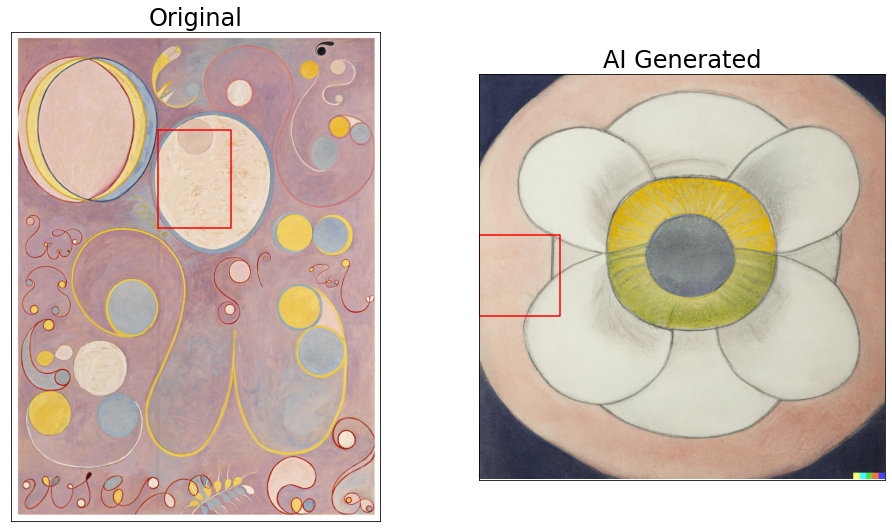

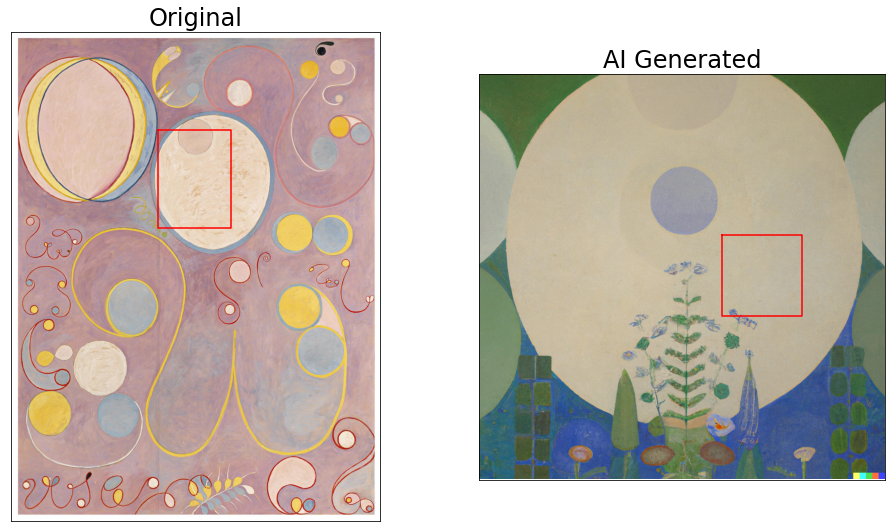

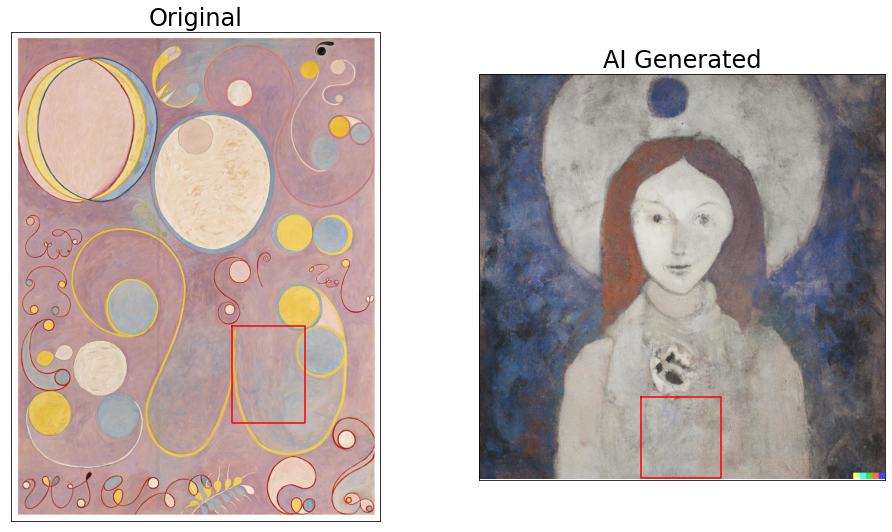

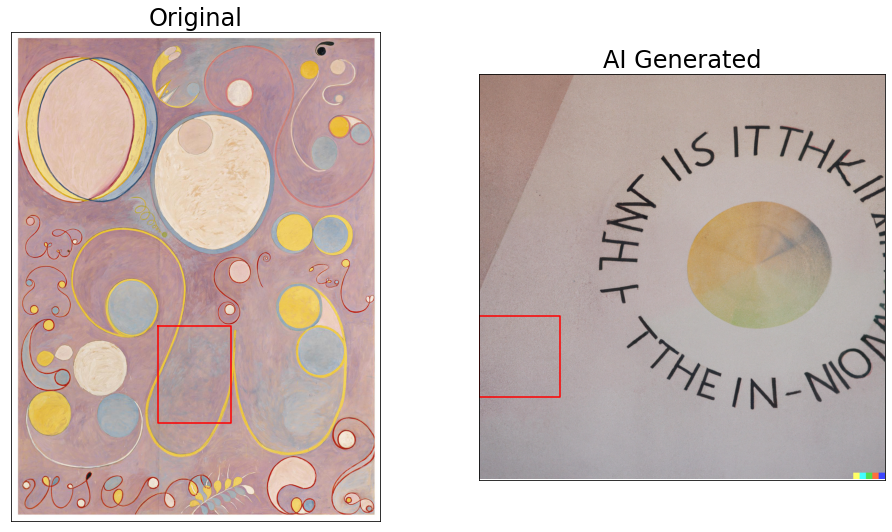

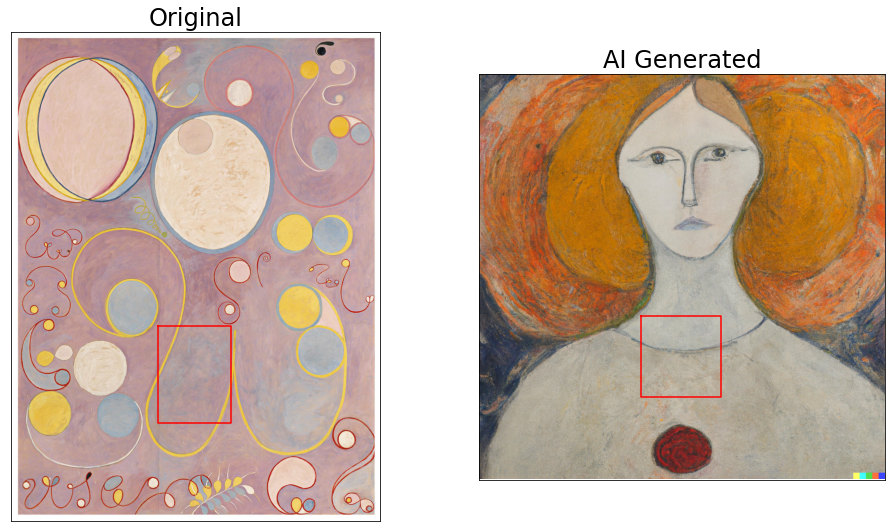

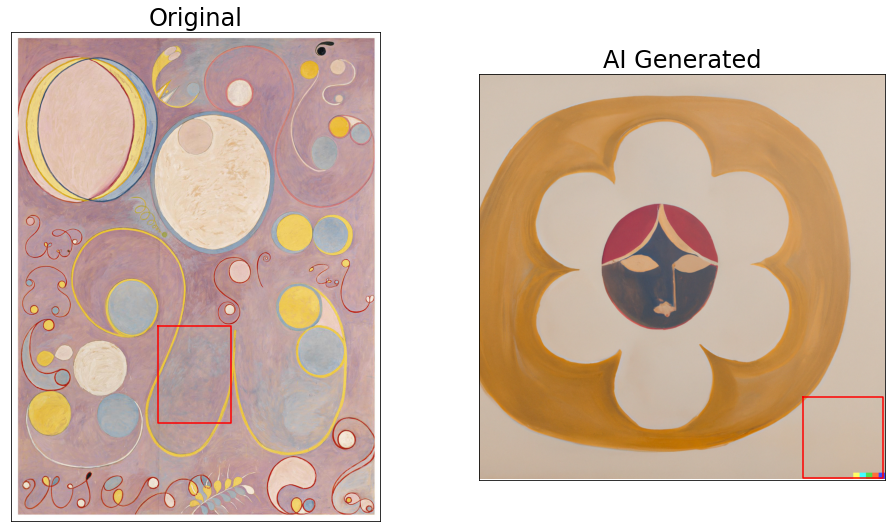

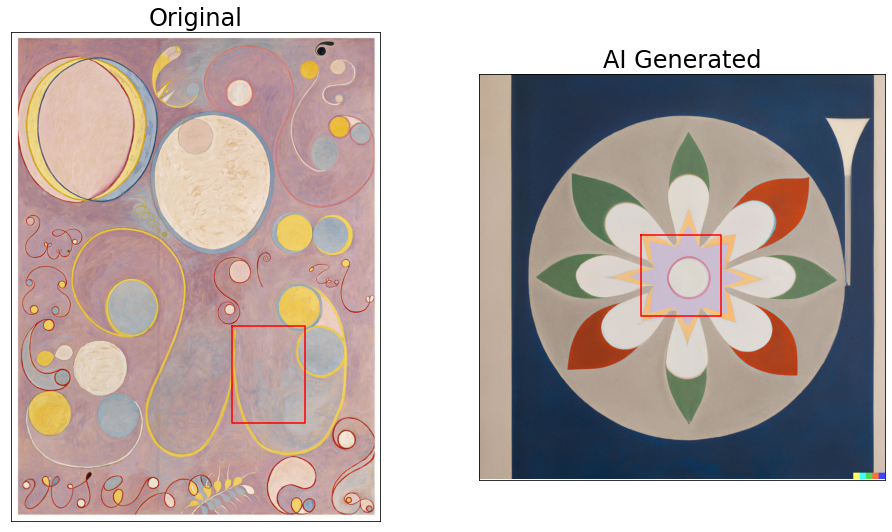

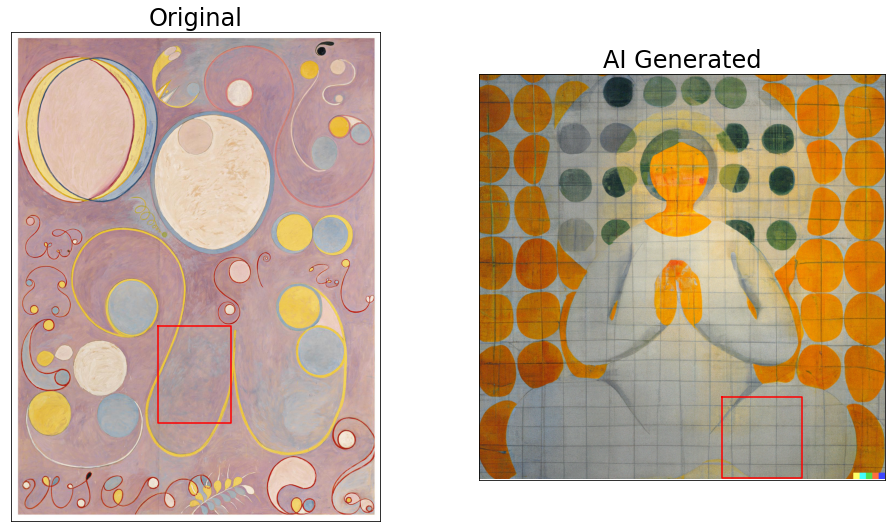

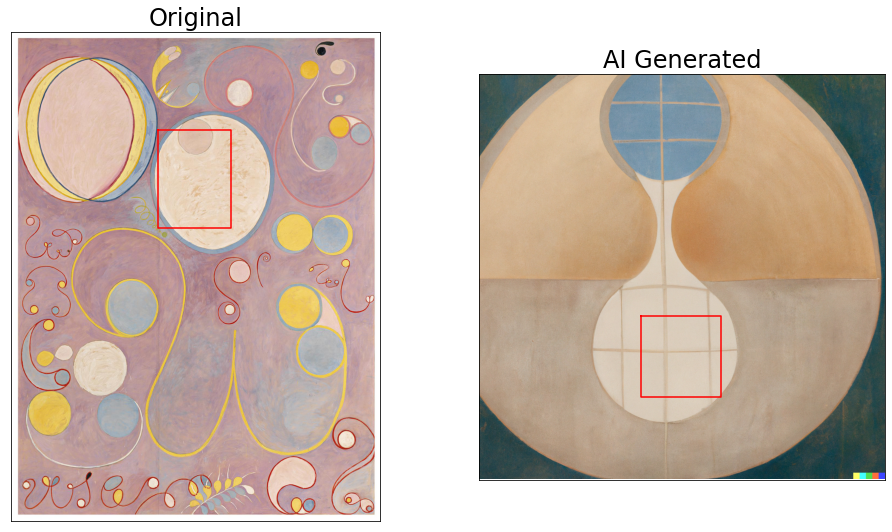

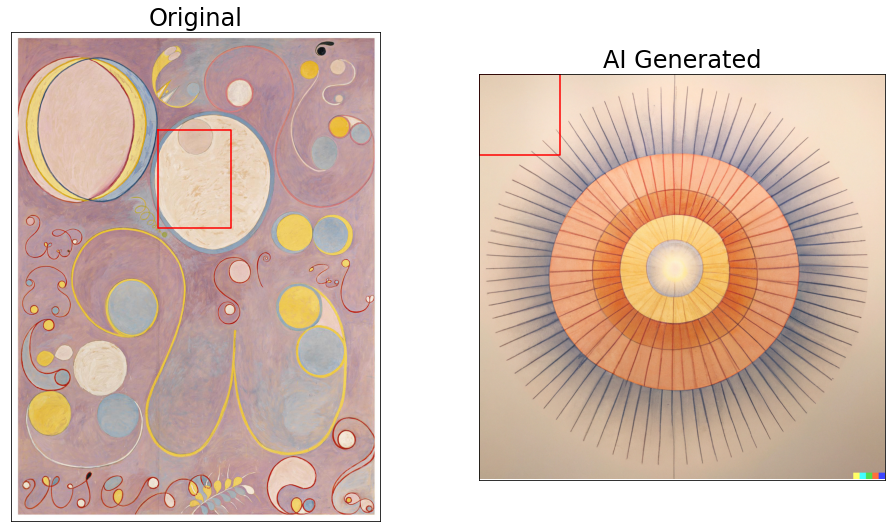

In [222]:
for i in range(10):
    org_match = set([combo[0] for combo in combos_of_interest[i][:1]]) # choose number of bounding boxes
    output_match = set([combo[1] for combo in combos_of_interest[i][:1]])
    print('org: ', org_match)
    print('gen: ', output_match)
    plot_comparison(img_of_interest[i][0], img_of_interest[i][1], org_highlight_idx = org_match, output_highlight_idx = output_match)

In [229]:
def plot_diff_tiles(org_tiles, output_tiles, combos):
    fig, axes = plt.subplots(10, 2, figsize = (4, 16))

    for idx, combo in enumerate(combos):
        axes[idx, 0].imshow(org_tiles[combo[0]])
        axes[idx, 1].imshow(output_tiles[combo[1]])
        
#plot_diff_tiles(org_tiles, output_tiles, sorted_combos[:10])

In [56]:
from hashlib import md5
from tqdm import tqdm
import os

def remove_duplicates_in_folder(folder, destination_folder):
    hash_list = []
    for file in tqdm(os.listdir(f"{folder}")):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.webp') or file.endswith('.png'):
            img = img_to_array(load_img(f'{folder}/{file}'))
            img_hash = md5(img).hexdigest()
            if img_hash not in hash_list:
                hash_list.append(img_hash)
                save_img(f'{destination_folder}/{file}', img)
    old_len = len(os.listdir(f'{folder}'))
    new_len = len(os.listdir(f'{destination_folder}'))
    print(f'Before: {old_len} images')
    print(f'After: {new_len} images')

# !mkdir ../raw_data/hilma_study_nodups

# remove_duplicates_in_folder(folder = '../raw_data/hilma_study', 
#                             destination_folder = '../raw_data/hilma_study_nodups')